## Exploring Rossmann Drug Store Sales Data

In [5]:
import pandas as pd

data = pd.read_csv('../../DSI-CHI-1/lessons/week-10/2.2-autocorrelation/assets/datasets/rossmann.csv', skipinitialspace=True, low_memory=False)
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-31,2,5,6064,625,1,1,0,1,2015,7
2015-07-31,3,5,8314,821,1,1,0,1,2015,7
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7
2015-07-31,5,5,4822,559,1,1,0,1,2015,7


In [7]:
store1_data = data[data.Store == 1]
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

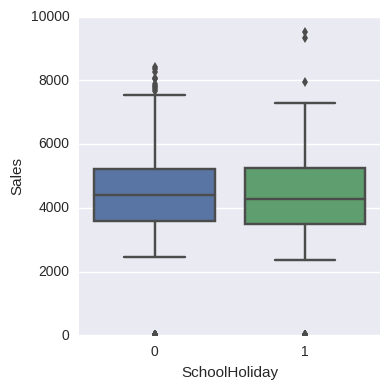

In [8]:
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

Check: See if there is a difference affecting sales on promotion days.

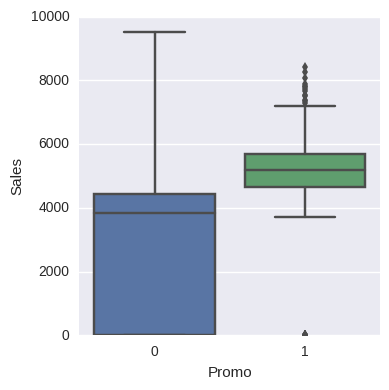

In [9]:
sb.factorplot(
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='box'
)

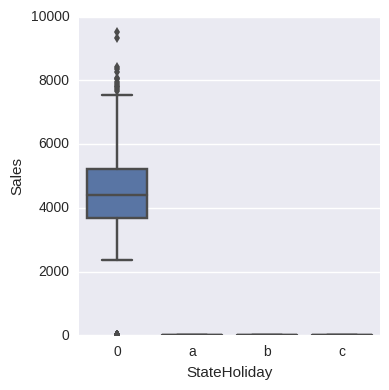

In [10]:
sb.factorplot(
    x='StateHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

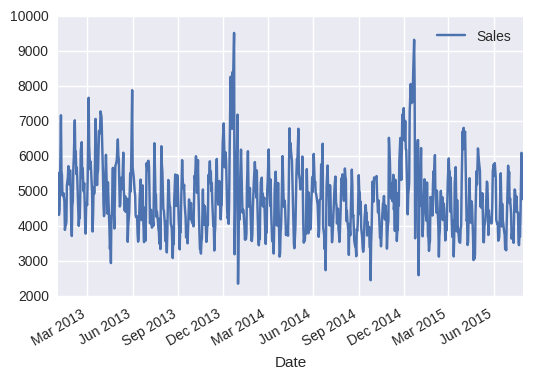

In [11]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

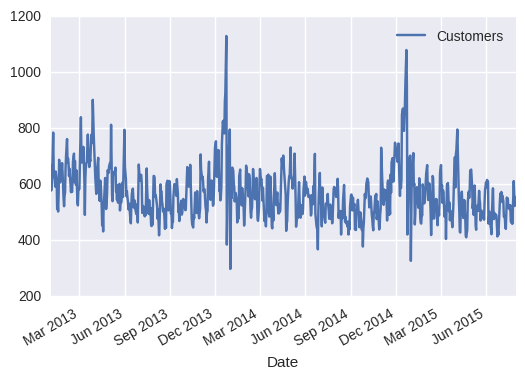

In [12]:
store1_open_data[['Customers']].plot()

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it. Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [8]:
data['Sales'].resample('D').mean().autocorr(lag=1)

-0.025858276006383588

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [11]:
import numpy as np
data[['Sales']].resample('M').apply([np.mean, np.median]).head()

Sales        
                   mean  median
Date                           
2013-01-31  5211.555578  5194.0
2013-02-28  5494.371397  5421.5
2013-03-31  5820.349168  5844.0
2013-04-30  5483.749836  5464.0
2013-05-31  5364.127383  5585.0

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [22]:
# Resample to have the daily average over all stores
daily_store_sales = data[['Sales']].resample('D').sum()

daily_store_sales.rolling(window=3, center=True).mean().head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,4.464961e+06
2013-01-03,6.645534e+06
2013-01-04,6.312789e+06
2013-01-05,4.244817e+06


`rolling_mean` (as well as `rolling_median`) takes these important parameters:
    - the first is the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

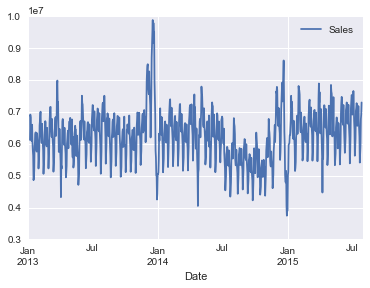

In [23]:
daily_store_sales.rolling(window=10, center=True).mean().plot()

### Pandas Window functions

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one argument, `periods`, which is how many rows prior to use for the difference.


In [24]:
data['Sales'].diff(periods=1).head()

Date
2015-07-31       NaN
2015-07-31     801.0
2015-07-31    2250.0
2015-07-31    5681.0
2015-07-31   -9173.0
Name: Sales, dtype: float64

### Pandas expanding functions

In addition to `rolling` functions, Pandas provides `expanding`, which, instead of using a window of N values, use all values up until that time.

In [26]:
# computes the average sales, from the first date _until_ the date specified.
daily_store_sales.expanding().mean().head()

,Sales
Date,
2013-01-01,9.723500e+04
2013-01-02,3.523532e+06
2013-01-03,4.464961e+06
2013-01-04,5.008460e+06
2013-01-05,5.197086e+06


In [29]:
data['Sales'].ewm(span=10).mean().head()

Date
2015-07-31    5263.000000
2015-07-31    5703.550000
2015-07-31    6752.933555
2015-07-31    9138.871782
2015-07-31    7899.615302
Name: Sales, dtype: float64

## Exercises

> Plot the distribution of sales by month and compare the effect of promotions

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

> Plot the 15 day rolling mean of customers in the stores

> Identify the date with largest drop in sales from the same date in the previous month

> Compute the total sales up until Dec. 2014

> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling` and `diff`